In [58]:
#! python -m pip install wget
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from astropy import coordinates as coord
from astropy import units as u

import wget

%matplotlib inline

### Query Hyperleda DB
Below is the query used to extract the data from the HL Database. The appropriate lines can be cut and pasted into the three boxes on the Leda website - http://leda.univ-lyon1.fr/fullsql.html if necessary or for testing purposes, otherwise, the script below will return the same data to a file.

SELECT
objname, al2000, de2000, l2, b2, ag, bve, t, type, v, e_v, (v/70), bt, e_bt, -(modbest-bt), it, e_it, ut, vt, modbest, e_modbest, 
10*(10^(modbest/5))/1E6, logd25, hl_names(pgc)

FROM meandata

WHERE
objtype = 'G' AND modbest between 26.5 AND 35.4 AND de2000>-30.0 AND -(modbest-bt)<-20

ORDER BY
bt


In [14]:
query_ur1="http://leda.univ-lyon1.fr/fG.cgi?n=meandata&c=o&of=1,leda,simbad&nra=l&nakd=1&d=objname%2C%20al2000%2C%20de2000%2C%20l2%2C%20b2%2C%20ag%2C%20bve%2C%20t%2C%20type%2C%20v%2C%20e_v%2C%20(v%2F70)%2C%20bt%2C%20e_bt%2C%20-(modbest-bt)%2C%20it%2C%20e_it%2C%20ut%2C%20vt%2C%20modbest%2C%20e_modbest%2C%20%0A10*(10%5E(modbest%2F5))%2F1E6%2C%20logd25%2C%20hl_names(pgc)&sql=objtype%20%3D%20%27G%27%20AND%20modbest%20between%2026.5%20AND%2035.4%20AND%20de2000%3E-30.0%20AND%20-(modbest-bt)%3C-20%0A&ob=bt&a=csv%5B%2C%5D"


'http://leda.univ-lyon1.fr/fG.cgi?n=meandata&c=o&of=1,leda,simbad&nra=l&nakd=1&d=objname%2C%20al2000%2C%20de2000%2C%20l2%2C%20b2%2C%20ag%2C%20bve%2C%20t%2C%20type%2C%20v%2C%20e_v%2C%20(v%2F70)%2C%20bt%2C%20e_bt%2C%20-(modbest-bt)%2C%20it%2C%20e_it%2C%20ut%2C%20vt%2C%20modbest%2C%20e_modbest%2C%20%0A10*(10%5E(modbest%2F5))%2F1E6%2C%20logd25%2C%20hl_names(pgc)&sql=objtype%20%3D%20%27G%27%20AND%20modbest%20between%2026.5%20AND%2035.4%20AND%20de2000%3E-30.0%20AND%20-(modbest-bt)%3C-20%0A&ob=bt&a=csv%5B%2C%5D'

In [37]:
base_url = "http://leda.univ-lyon1.fr/fG.cgi"
query_type = "c=o"
selection = "n=meandata"
param1 = "of=1,leda,simbad"
param2 = "nra=l"
param3 = "nakd=1"
SELECT = "d=objname%2C%20al2000%2C%20de2000%2C%20l2%2C%20b2%2C%20ag%2C%20bve%2C%20t%2C%20type%2C%20v%2C%20e_v%2C%20(v%2F70)%2C%20bt%2C%20e_bt%2C%20-(modbest-bt)%2C%20it%2C%20e_it%2C%20ut%2C%20vt%2C%20modbest%2C%20e_modbest%2C%2010*(10%5E(modbest%2F5))%2F1E6%2C%20logd25%2C%20hl_names(pgc)" # %2C%20hl_names(pgc)
WHERE = "sql=objtype%20%3D%20%27G%27%20AND%20modbest%20between%2026.5%20AND%2035.4%20AND%20de2000%3E-30.0%20AND%20-(modbest-bt)%3C-20%0A"
ORDER_BY = "ob=bt"
format_type = "a=csv%5B%7C%5D"

query_url = '?'.join([base_url, selection])
query_url = '&'.join([query_url, query_type, param1, param2, param3, SELECT, WHERE, ORDER_BY, format_type])
# query_url="http://leda.univ-lyon1.fr/fG.cgi?n=meandata&c=o&of=1,leda,simbad&nra=l&nakd=1&d=objname%2C%20al2000%2C%20de2000%2C%20l2%2C%20b2%2C%20ag%2C%20bve%2C%20t%2C%20type%2C%20v%2C%20e_v%2C%20(v%2F70)%2C%20bt%2C%20e_bt%2C%20-(modbest-bt)%2C%20it%2C%20e_it%2C%20ut%2C%20vt%2C%20modbest%2C%20e_modbest%2C%20%0A10*(10%5E(modbest%2F5))%2F1E6%2C%20logd25%2C%20hl_names(pgc)&sql=objtype%20%3D%20%27G%27%20AND%20modbest%20between%2026.5%20AND%2035.4%20AND%20de2000%3E-30.0%20AND%20-(modbest-bt)%3C-20%0A&ob=bt&a=csv%5B%2C%5D"
filename = wget.download(query_url,out='data/HLG2.csv')
filename


'data/HLG2.csv'

### Hyperleda Galaxy extract
First we load up the HL data extract which has been selected and filtered as described previously (SQL above). This includes 4812 galaxies which meet the filter criteria (i.e. 2 < dist_Mpc < 120 MPC, Bmag < -20 mag, object type = 'G' and Dec > -30)

In [115]:
# Now load HL data from downloaded file - header and ignored lines at start of file should be set 
# depending upon length of parameter list

with open('data/HLG2.csv') as f:
    HLdata_full = pd.read_csv(f, header=0, sep='|', skip_blank_lines=True, comment='#', skipinitialspace=True)

HLdata_full.columns

Index(['objname', 'al2000', 'de2000', 'l2', 'b2', 'ag', 'bve', 't', 'type',
       'v', 'e_v', '(v/70)', 'bt', 'e_bt', '-(modbest-bt)', 'it', 'e_it', 'ut',
       'vt', 'modbest', 'e_modbest', '10*(10^(modbest/5))/1E6', 'logd25',
       'hl_names(pgc)'],
      dtype='object')

The format / columns of the CSV file loaded is as shown above, with example data below.

In [179]:
HLdata_full.head()

,objname,al2000,de2000,l2,b2,ag,bve,t,type,v,...,-(modbest-bt),it,e_it,ut,vt,modbest,e_modbest,10*(10^(modbest/5))/1E6,logd25,hl_names(pgc)
0,NGC5236,13.616927,-29.865626,314.583657,31.972863,0.288,0.720,5.0,Sc,508.4,...,-20.633,NaN,NaN,7.847,7.214,28.450,0.024,4.897790,2.134,"2MASXJ13370091-2951567,ESO444-081,ESOLV4440810..."
1,NGC5457,14.053491,54.349023,102.037311,59.771285,0.037,0.585,5.9,SABc,236.9,...,-20.899,NaN,NaN,NaN,7.902,29.260,0.010,7.112136,2.380,"2MASXJ14031258+5420555,ARP026,CGCG272-021,IRAS..."
2,NGC5194,13.497970,47.195151,104.851473,68.560882,0.152,0.680,4.0,SABb,460.8,...,-21.059,NaN,NaN,NaN,10.722,29.667,0.023,8.578275,2.137,"2MASXJ13295269+4711429,ARP085:,CGCG246-008,IRA..."
3,NGC4258,12.315996,47.303882,138.319830,68.842281,0.071,0.805,4.0,Sbc,454.2,...,-20.282,7.356,0.078,NaN,9.293,29.406,0.011,7.606765,2.230,"2MASXJ12185761+4718133,CGCG243-067,CGCG244-003..."
4,NGC4594,12.666513,-11.623010,298.460680,51.149343,0.221,1.025,1.1,Sa,1087.5,...,-20.519,7.050,0.100,9.684,8.587,29.673,0.060,8.602012,1.927,"2MASXJ12395949-1137230,IRAS12373-1120,MCG-02-3..."


In [351]:
class Sky:
    def __init__(self):
        self.cmap = cm.get_cmap('inferno_r')
        self.fig, self.ax = self.create()

    def create(self):
        self.fig = plt.figure(figsize=(10, 5), dpi=300)
        self.ax = self.fig.add_subplot(111, projection="mollweide")
        self.ax.set_title("Host galaxy locations")
        self.ax.set_xticklabels(['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h'])
        self.ax.grid(True)
        norm = colors.Normalize(vmin=0.02, vmax=2.1)
        self.fig.colorbar(cm.ScalarMappable(norm=norm, cmap=self.cmap), label='Galactic Extinction (B-band)', shrink=.75, pad=.03,
                          aspect=20)
        return self.fig, self.ax

    def ax(self):
        return self.ax

    def show(self, name):
        if not os.path.isdir('figures'):
            os.makedirs('figures')

        # self.fig.show()
        self.fig.savefig(f'figures/{name}.png')


def plotSkyObjects(sky: Sky, samples):
    ra = coord.Angle(samples['al2000'] * 15 * u.degree)
    ra = ra.wrap_at(180 * u.degree)
    dec = coord.Angle(samples['de2000'] * u.degree)  # .filled(np.nan)
    size = samples['logd25']*400
    sky.ax.scatter(ra.radian, dec.radian,
                   marker='.',
                   c=samples['ag'],
                   cmap=sky.cmap, vmin=0.02, vmax=2.1, alpha=0.9)


def skyplot(samples, name):
    sampleProjection = Sky()
#     utilities.startup('Data sample sky projection')
#     objectsList = getObjectsCSV()
    plotSkyObjects(sampleProjection, samples)
    sampleProjection.show(name)
    print(samples[['ag']].describe())



                ag
count  4812.000000
mean      0.222799
std       0.180645
min       0.020000
25%       0.105000
50%       0.166000
75%       0.284000
max       2.099000


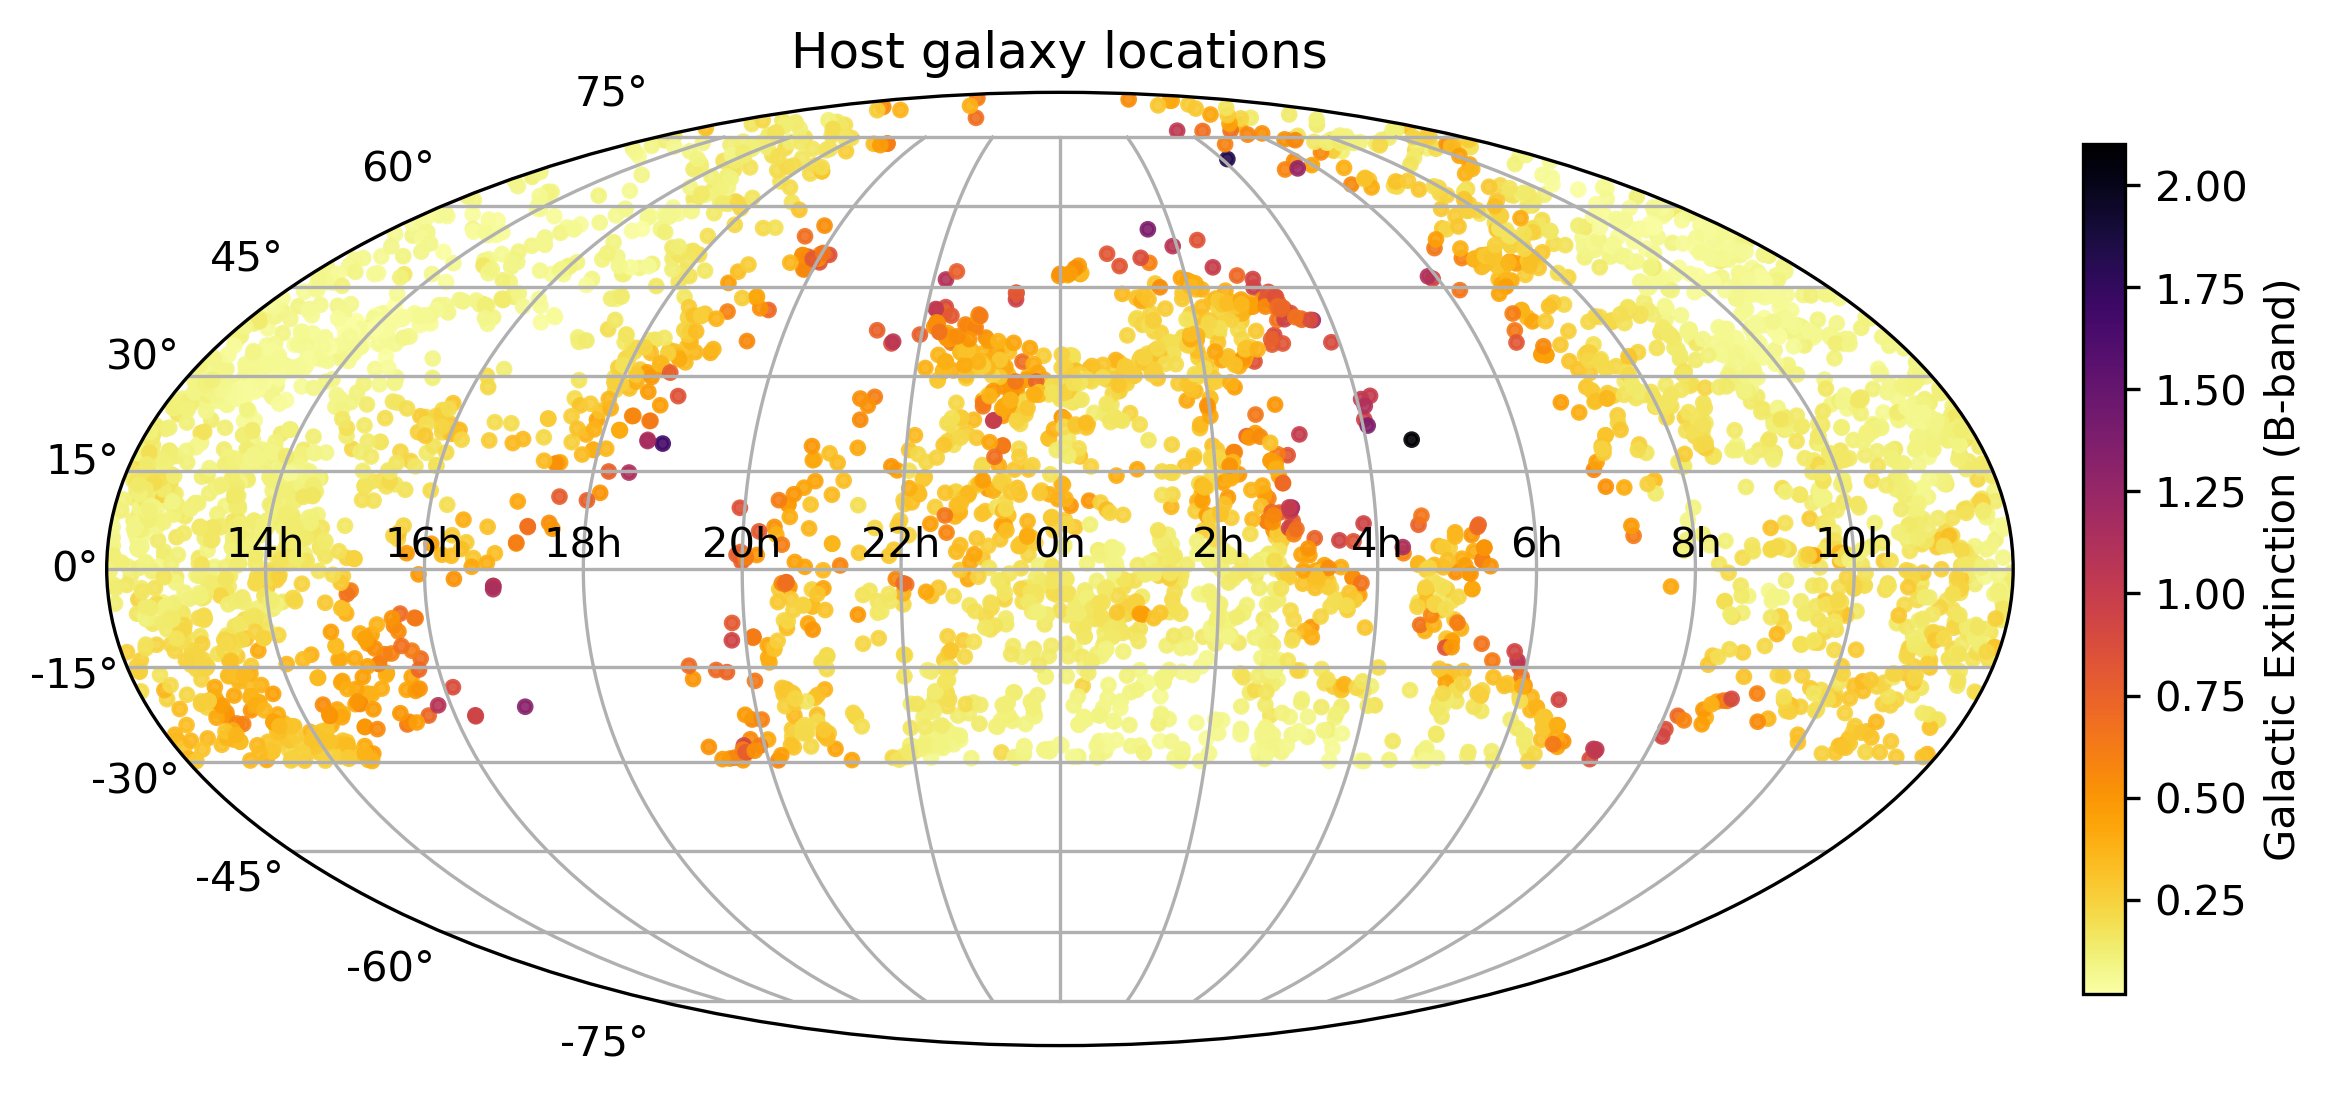

In [352]:
skyplot(HLdata_full,'HGL_full')

               ag
count  3714.00000
mean      0.14632
std       0.06810
min       0.02000
25%       0.09300
50%       0.13500
75%       0.19600
max       0.29900


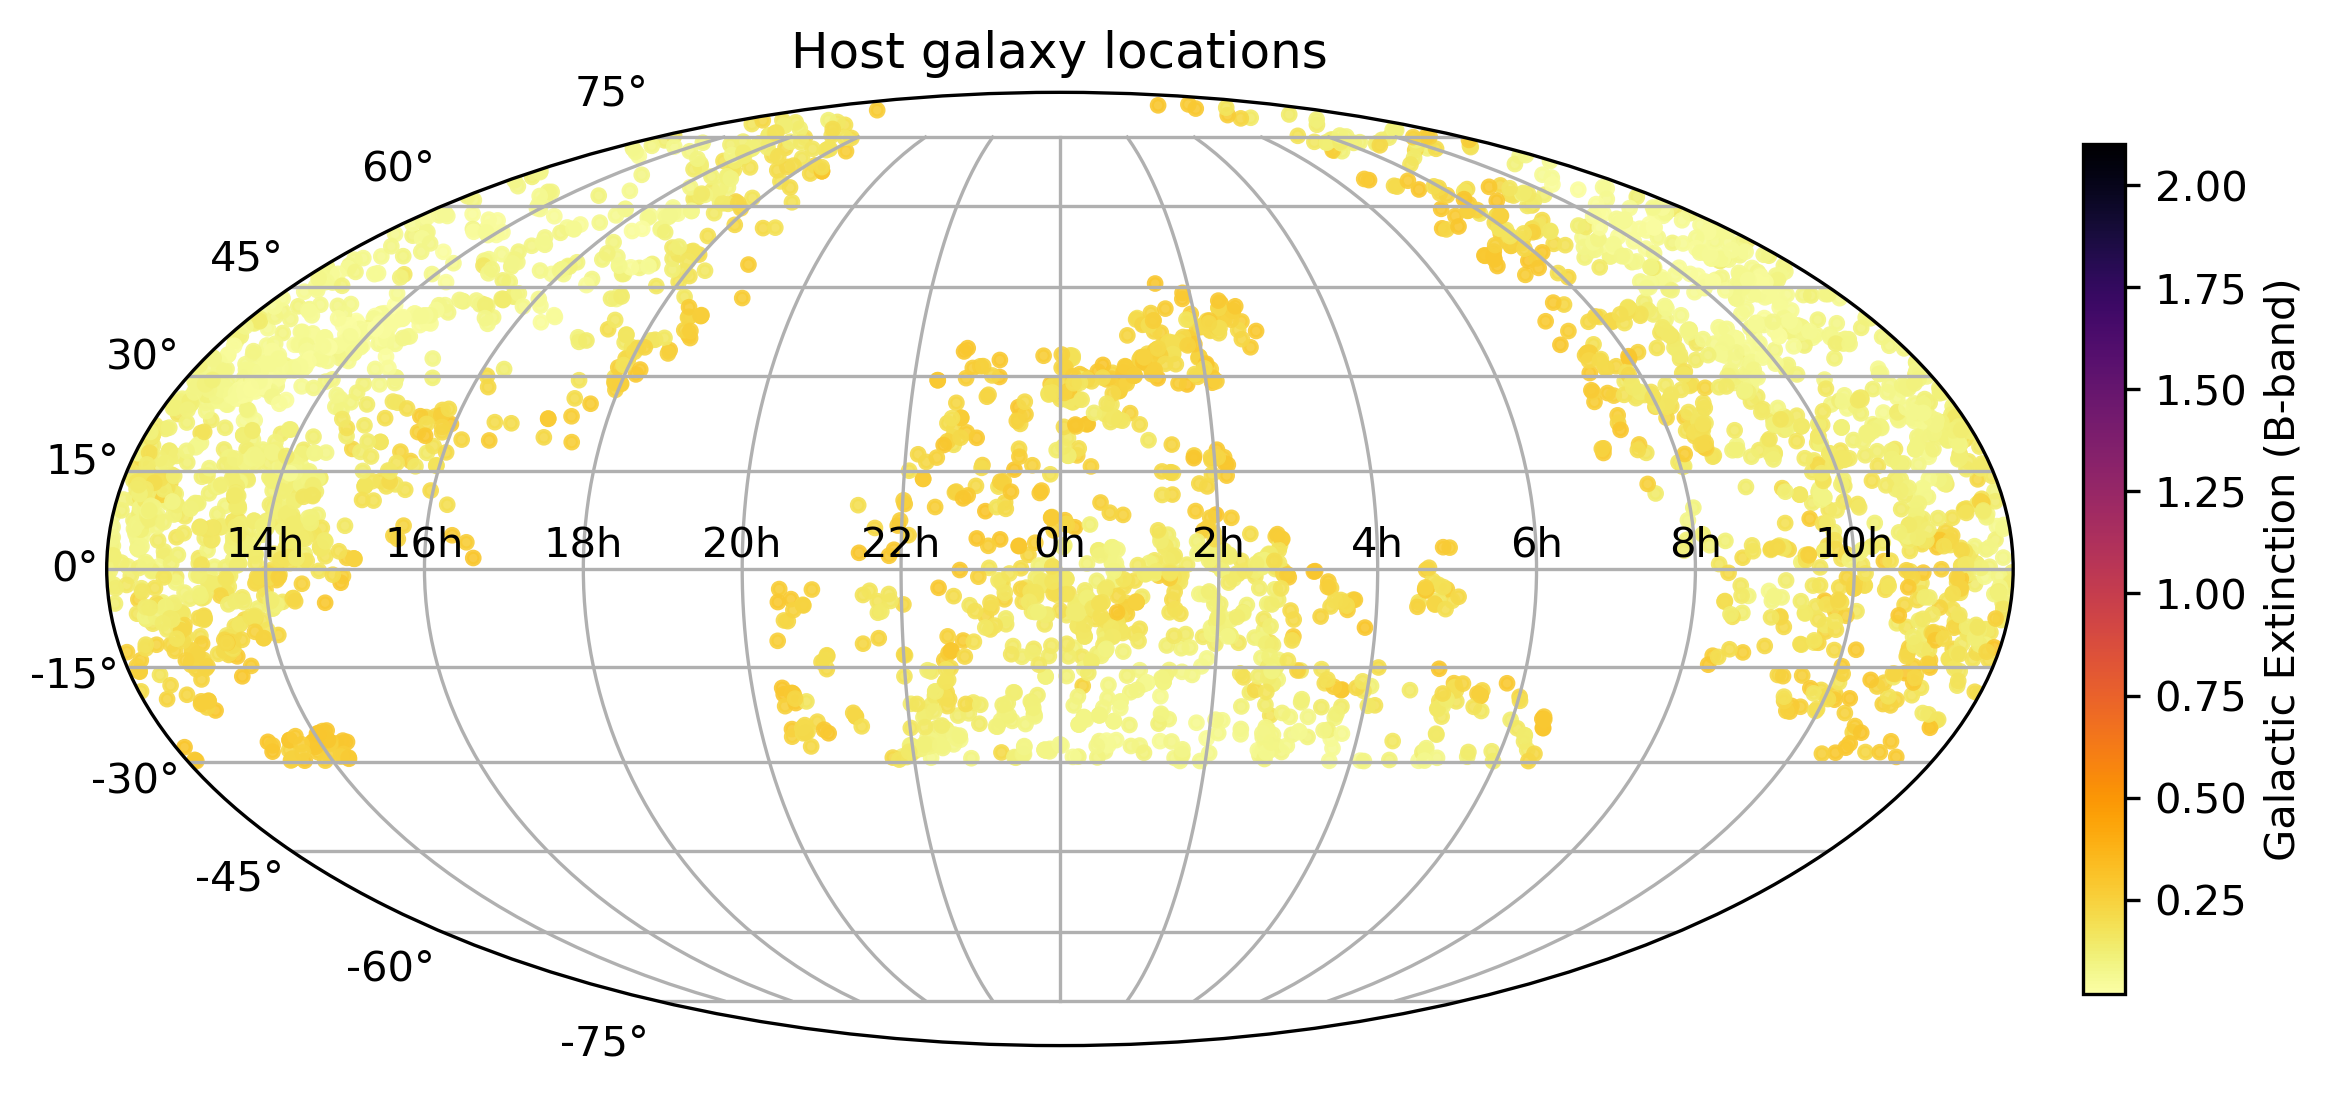

In [353]:
ex_threshold = 0.3
skyplot(HLdata_full[HLdata_full['ag']<ex_threshold],'HGL_ext_min')

In [275]:
HLdata = HLdata_full[HLdata_full['ag']<ex_threshold]

In [276]:
HLdata[['bt','vt']].head(100)

,bt,vt
0,7.817,7.214
1,8.361,7.902
2,8.608,10.722
3,9.124,9.293
4,9.154,8.587
...,...,...
105,11.416,10.621
106,11.418,10.508
107,11.437,10.876
108,11.441,10.620


In [277]:
HLdata = HLdata.set_axis(
    ['Name', 'RA', 'DEC', 'l', 'b', 'extinct', 'eff_B-V', 't', 'type', 'v', 'e_v', 'dist_Hf', 'bt', 'e_bt', 'Bmagt', 'it', 'e_it', 'ut', 'vt',
     'modbest', 'e_modbest', 'dist_Mpc', 'logd25', 'hl_names(pgc)'], axis=1, inplace=False)
# RA from Hyperleda is RA in hrs, decimal. Need to convert to degrees
HLdata['RA'] = HLdata['RA'] * 15
# logd25 is in 0.1 arcmin, so /10 gives arcmin, *60 gives arcsec... *6
HLdata['appDiam_arcsec'] = (10 ** HLdata['logd25'] * 6)
# dist_Mod is in Mpc, so *1000 to give kpc
HLdata['appDiam_kpc'] = ((HLdata['dist_Mpc'] * (HLdata['appDiam_arcsec'])) / 206.265)
# HLdata['est_vt'] = -(HLdata['eff_B-V'] - HLdata['bt'])

HLdata.columns

Index(['Name', 'RA', 'DEC', 'l', 'b', 'extinct', 'eff_B-V', 't', 'type', 'v',
       'e_v', 'dist_Hf', 'bt', 'e_bt', 'Bmagt', 'it', 'e_it', 'ut', 'vt',
       'modbest', 'e_modbest', 'dist_Mod', 'logd25', 'hl_names(pgc)',
       'appDiam_arcsec', 'appDiam_kpc'],
      dtype='object')

In [546]:
class Sky2:
    def __init__(self):
        self.cmap = cm.get_cmap('viridis')
        self.fig, self.ax = self.create()

    def create(self):
        self.fig = plt.figure(figsize=(10, 5), dpi=300)
        self.ax = self.fig.add_subplot(111, projection="mollweide")
        self.ax.set_title("Host galaxy locations")
        self.ax.set_xticklabels(['14h', '16h', '18h', '20h', '22h', '0h', '2h', '4h', '6h', '8h', '10h'])
        self.ax.grid(True)
        norm = colors.Normalize(vmin=-22.7, vmax=-20)
        self.fig.colorbar(cm.ScalarMappable(norm=norm, cmap=self.cmap), label='Absolute B-mag', shrink=.75, pad=.03,
                          aspect=20)
        return self.fig, self.ax

    def ax(self):
        return self.ax

    def show(self, name):
#         self.fig.legend(*self.ax.legend_elements("sizes", num=4))

        if not os.path.isdir('figures'):
            os.makedirs('figures')

        # self.fig.show()
        self.fig.savefig(f'figures/{name}.png')


def plotSkyObjects(sky: Sky2, samples):
    ra = coord.Angle(samples['RA'] * u.degree)
    ra = ra.wrap_at(180 * u.degree)
    dec = coord.Angle(samples['DEC'] * u.degree)  # .filled(np.nan)
    size = samples['dist_Mpc']/10
    sky.ax.scatter(ra.radian, dec.radian,
                   marker='o',
                   c=samples['Bmagt'],
                   s=5,
                   cmap=sky.cmap, vmin=-22.7, vmax=-20, alpha=0.9)



def skyplot2(samples, name):
    sampleProjection = Sky2()
#     utilities.startup('Data sample sky projection')
#     objectsList = getObjectsCSV()
    plotSkyObjects(sampleProjection, samples)
    sampleProjection.show(name)
#     print(samples[['ag']].describe())



In [547]:
print(np.min(HLdata['Bmagt']))
(53.4-(-np.min(HLdata['Bmagt'])+HLdata['Bmagt'])*20).describe()

-22.617


count    3714.000000
mean       10.704120
std         8.092321
min         1.060000
25%         4.385000
50%         8.720000
75%        14.835000
max        53.400000
Name: Bmagt, dtype: float64

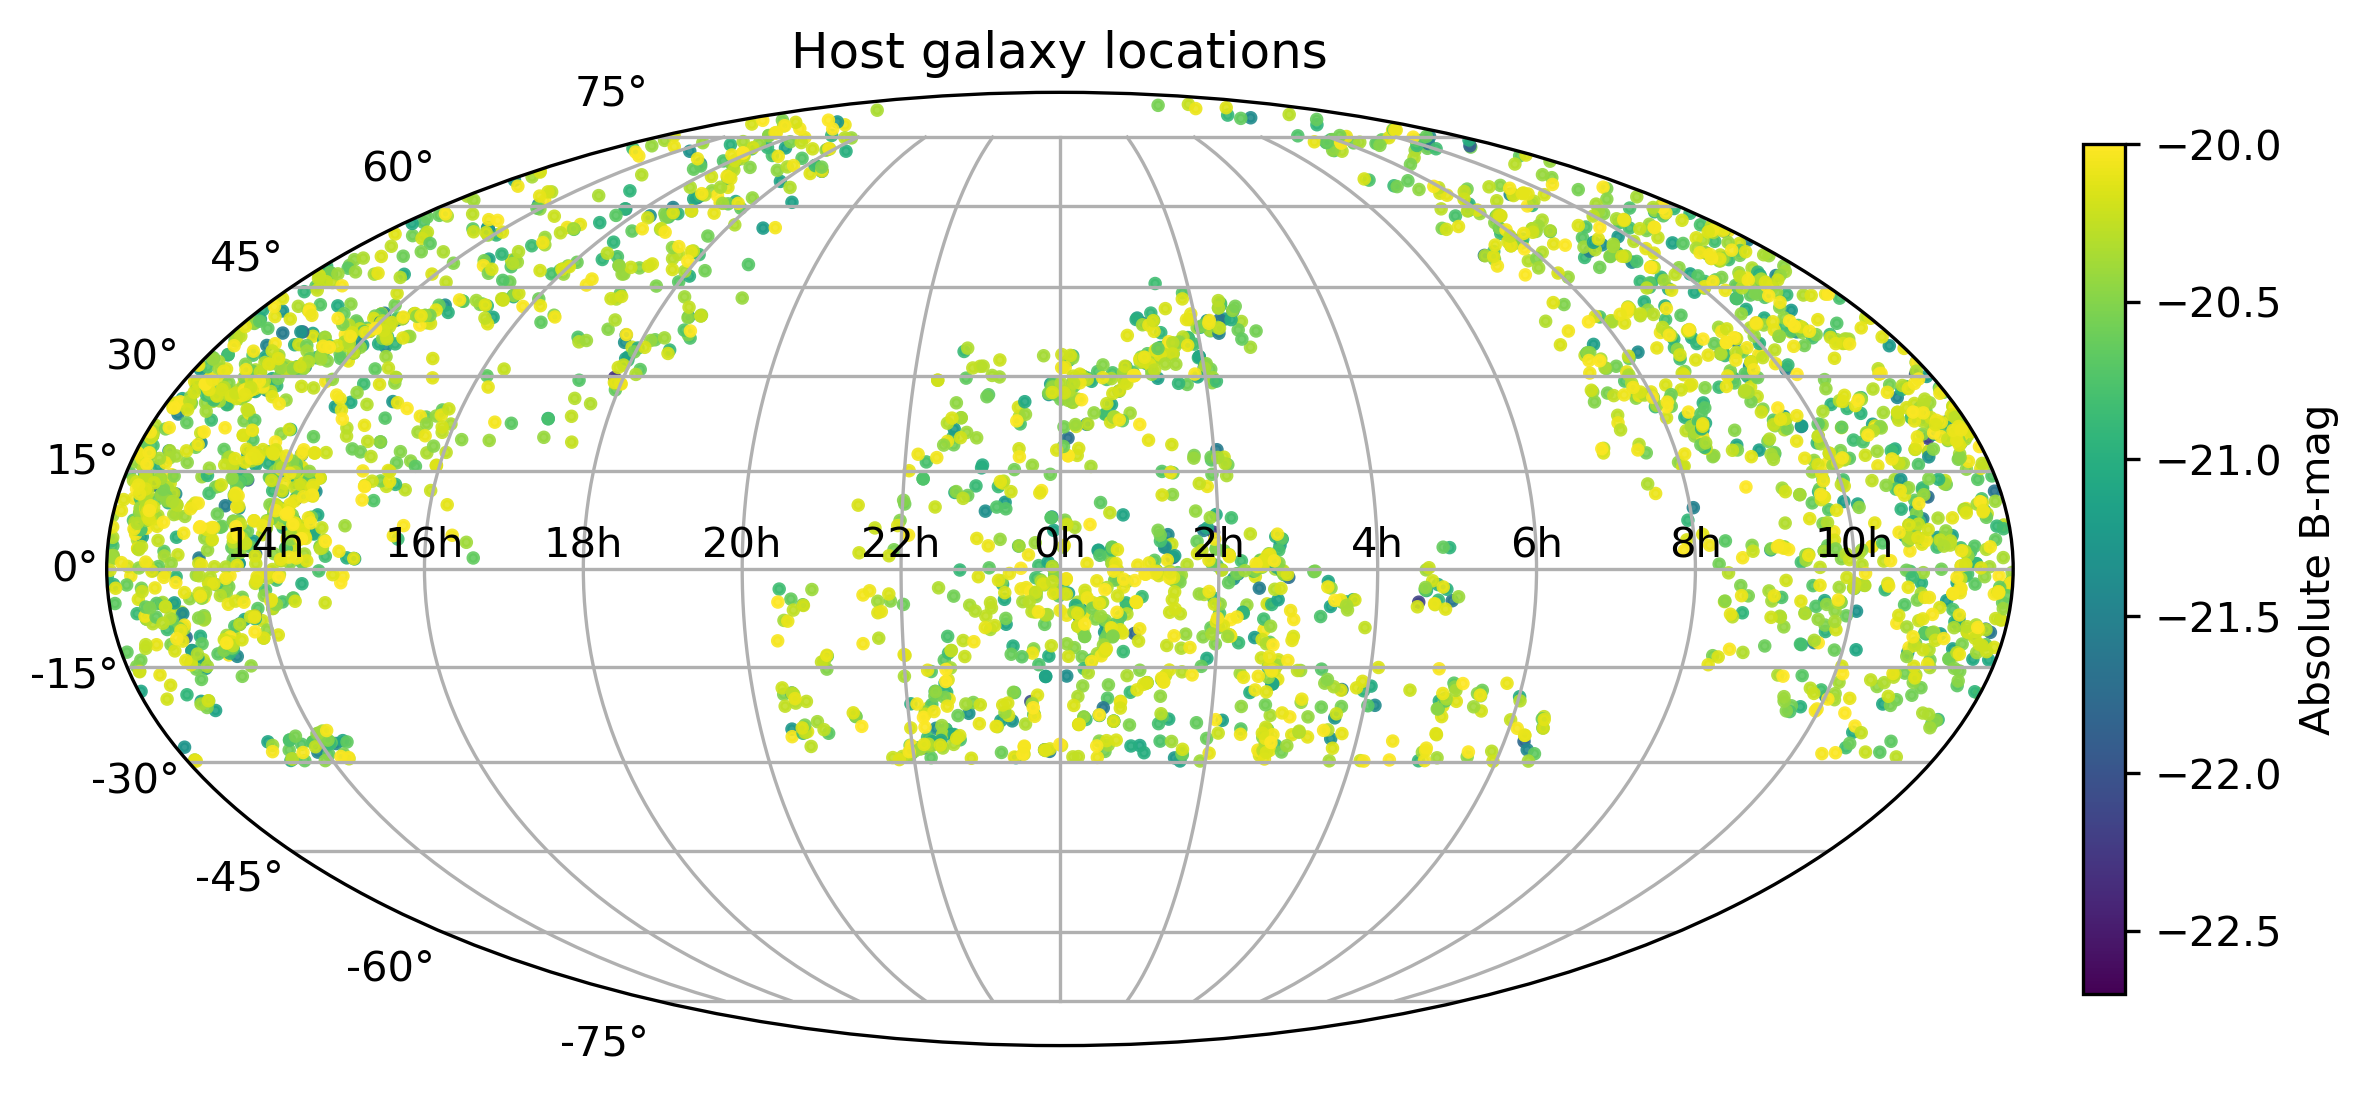

In [548]:
skyplot2(HLdata,'HGL_ext_min2')

### Estimate vt from existing bt
Since not all rows in DB have vt, and this is required to determine the GC Specific Frequency (see below) first thing needed is a straight-line gradient/intercept. Below is the vt vs. bt for existing values.

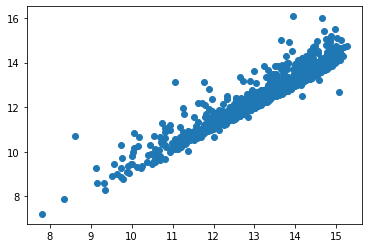

In [237]:
plt.scatter(HLdata['bt'], HLdata['vt'])

In [238]:
from numpy.polynomial import polynomial as P

def bestfit(x, y, deg):
    c = P.polyfit(x, y, deg, rcond=None, full=False, w=None)
    return c

Create temp DataFrame with only bt and vt values, and remove NA values (from vt) which upset the polynomial method above.

In [239]:
HLtemp = pd.DataFrame([HLdata['bt'], HLdata['vt']])
# linear = bestfit(HLdata['bt'], HLdata['vt'], 1)
# linear
HLtemp2 = HLtemp.transpose().dropna()
HLtemp2

,bt,vt
0,7.817,7.214
1,8.361,7.902
2,8.608,10.722
3,9.124,9.293
4,9.154,8.587
...,...,...
4394,15.101,14.361
4407,15.108,15.000
4539,15.166,14.286
4582,15.188,14.718


In [240]:
c,m = bestfit(HLtemp2['bt'], HLtemp2['vt'], 1)
c,m


(-0.14056727347127373, 0.9605086124094615)

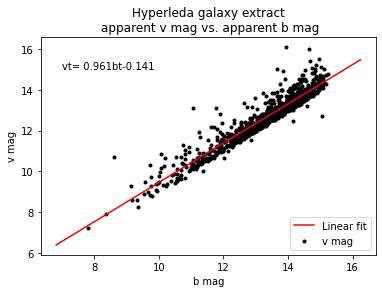

In [308]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xmin = np.min(HLtemp2['bt'])
xmax = np.max(HLtemp2['bt'])
x = np.linspace(xmin-1,xmax+1,100)
y = m*x + c
# ax.spines['left'].set_position('center')
# ax.spines['bottom'].set_position('center')
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')
plt.scatter(HLtemp2['bt'], HLtemp2['vt'], label='v mag', marker='.', c='black')
plt.plot(x, y, '-r', label=f'Linear fit')

plt.legend(loc='lower right')
plt.xlabel('b mag')
plt.ylabel('v mag')
plt.title('Hyperleda galaxy extract\n apparent v mag vs. apparent b mag')
plt.text(7, 15, f'vt={m:6.3f}bt{c:+5.3f}')
plt.show()

Now with our straight-line approximation we can estimate (very roughly!) the missing vt values in the original DataFrame as 'est_vt', and similarly for the 'est_Vmagt'.

In [279]:
HLdata['est_vt']=HLdata['vt'].mask(np.isnan(HLdata['vt']),m*HLdata['bt']+c,axis=0,inplace=False)
HLdata['est_Vmagt']=-(HLdata['modbest']-HLdata['est_vt'])
HLdata

,Name,RA,DEC,l,b,extinct,eff_B-V,t,type,v,...,vt,modbest,e_modbest,dist_Mod,logd25,hl_names(pgc),appDiam_arcsec,appDiam_kpc,est_vt,est_Vmagt
0,NGC5236,204.253901,-29.865626,314.583657,31.972863,0.288,0.720,5.0,Sc,508.4,...,7.214,28.450,0.024,4.897790,2.134,"2MASXJ13370091-2951567,ESO444-081,ESOLV4440810...",816.866809,19.396611,7.214000,-21.236000
1,NGC5457,210.802368,54.349023,102.037311,59.771285,0.037,0.585,5.9,SABc,236.9,...,7.902,29.260,0.010,7.112136,2.380,"2MASXJ14031258+5420555,ARP026,CGCG272-021,IRAS...",1439.299751,49.627884,7.902000,-21.358000
2,NGC5194,202.469547,47.195151,104.851473,68.560882,0.152,0.680,4.0,SABb,460.8,...,10.722,29.667,0.023,8.578275,2.137,"2MASXJ13295269+4711429,ARP085:,CGCG246-008,IRA...",822.529060,34.207842,10.722000,-18.945000
3,NGC4258,184.739936,47.303882,138.319830,68.842281,0.071,0.805,4.0,Sbc,454.2,...,9.293,29.406,0.011,7.606765,2.230,"2MASXJ12185761+4718133,CGCG243-067,CGCG244-003...",1018.946191,37.577314,9.293000,-20.113000
4,NGC4594,189.997701,-11.623010,298.460680,51.149343,0.221,1.025,1.1,Sa,1087.5,...,8.587,29.673,0.060,8.602012,1.927,"2MASXJ12395949-1137230,IRAS12373-1120,MCG-02-3...",507.167307,21.150750,8.587000,-21.086000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4804,PGC021278,113.325916,32.546028,186.671819,22.432541,0.212,NaN,4.8,Sc,8032.0,...,NaN,35.356,0.135,117.814786,0.869,"2MASXJ07331822+3232457,CGCG147-035,CGCG177-032...",44.376317,25.346938,14.606121,-20.749879
4806,PGC2082878,206.475387,36.565902,75.597780,75.099876,0.053,NaN,-0.3,S0-a,7943.9,...,NaN,35.390,0.133,119.674019,0.840,"2MASXJ13455410+3633571,PGC2082878,SDSSJ134554....",41.509858,24.083832,14.609963,-20.780037
4807,UGC11901,331.342182,5.183812,65.424645,-38.495908,0.232,NaN,3.3,Sb,8108.7,...,NaN,35.390,0.133,119.674019,0.948,"2MASXJ22052213+0511018,2MFGC16657,CGCG403-021,...",53.229361,30.883434,14.610924,-20.779076
4809,PGC020057,105.745999,18.538222,197.511316,10.805060,0.243,NaN,NaN,NaN,8190.0,...,NaN,35.378,0.134,119.014444,0.650,"2MASXJ07025904+1832176,CGCG085-023,NPM1G+18.01...",26.801016,15.464126,14.619569,-20.758431


### Specific frequency and number of GCs (Ngc)
Given the estimated point of specific frequency from Peng et al. (2008), we can again estimate a polynomial to fit other points in our recently calculated Mv estimation.

|   Mv  |  Sn |
|:-----:|:---:|
| -22.5 |  4  |
| -21.3 | 2.2 |
| -20.5 | 1.3 |
| -19.5 | 1.3 |
| -18.7 | 1.7 |
| -17.5 | 2.7 |
| -16.4 | 3.1 |

In [281]:
SF_points=pd.DataFrame(data={'Mv': [-22.5, -21.3, -20.5, -19.5, -18.7, -17.5, -16.4], 
                             'Sn': [4, 2.2, 1.3, 1.3, 1.7, 2.7, 3.1]})
SF_poly = bestfit(SF_points['Mv'], SF_points['Sn'], 3)
SF_poly

array([-2.56145268e+02, -4.49367564e+01, -2.56296167e+00, -4.79900193e-02])

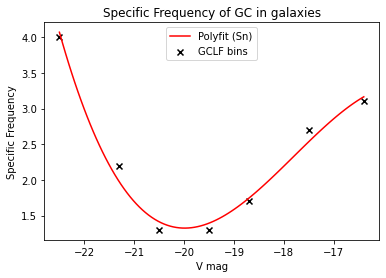

In [295]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
xmin = np.min(SF_points['Mv'])
xmax = np.max(SF_points['Mv'])
x = np.linspace(xmin,xmax,100)
y = SF_poly[3]*x**3 + SF_poly[2]*x**2 + SF_poly[1]*x + SF_poly[0]
# ax.spines['left'].set_position('center')
# ax.spines['bottom'].set_position('center')
# ax.spines['right'].set_color('none')
# ax.spines['top'].set_color('none')
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')
plt.plot(x, y, '-r', label='Polyfit (Sn)') # label=f'vt={m:6.3f}bt{c:+5.3f}'
plt.scatter(SF_points['Mv'], SF_points['Sn'],marker='x',c='black',label='GCLF bins')

plt.legend(loc='upper center')
plt.xlabel('V mag')
plt.ylabel('Specific Frequency')
plt.title('Specific Frequency of GC in galaxies')
plt.show()

Now with this, the V mag can finally be used to calculate the SF and of course, the Ngc for each galaxy.

In [315]:
HLdata['Sn'] = SF_poly[3]*HLdata['est_Vmagt']**3 + SF_poly[2]*HLdata['est_Vmagt']**2 + SF_poly[1]*HLdata['est_Vmagt'] + SF_poly[0]
HLdata['Ngc'] = np.int64(HLdata['Sn']/(10**(0.4*(HLdata['est_Vmagt']+15))))

HLdata

,Name,RA,DEC,l,b,extinct,eff_B-V,t,type,v,...,e_modbest,dist_Mod,logd25,hl_names(pgc),appDiam_arcsec,appDiam_kpc,est_vt,est_Vmagt,Sn,Ngc
0,NGC5236,204.253901,-29.865626,314.583657,31.972863,0.288,0.720,5.0,Sc,508.4,...,0.024,4.897790,2.134,"2MASXJ13370091-2951567,ESO444-081,ESOLV4440810...",816.866809,19.396611,7.214000,-21.236000,1.907187,595
1,NGC5457,210.802368,54.349023,102.037311,59.771285,0.037,0.585,5.9,SABc,236.9,...,0.010,7.112136,2.380,"2MASXJ14031258+5420555,ARP026,CGCG272-021,IRAS...",1439.299751,49.627884,7.902000,-21.358000,2.037669,711
2,NGC5194,202.469547,47.195151,104.851473,68.560882,0.152,0.680,4.0,SABb,460.8,...,0.023,8.578275,2.137,"2MASXJ13295269+4711429,ARP085:,CGCG246-008,IRA...",822.529060,34.207842,10.722000,-18.945000,1.614538,61
3,NGC4258,184.739936,47.303882,138.319830,68.842281,0.071,0.805,4.0,Sbc,454.2,...,0.011,7.606765,2.230,"2MASXJ12185761+4718133,CGCG243-067,CGCG244-003...",1018.946191,37.577314,9.293000,-20.113000,1.330168,147
4,NGC4594,189.997701,-11.623010,298.460680,51.149343,0.221,1.025,1.1,Sa,1087.5,...,0.060,8.602012,1.927,"2MASXJ12395949-1137230,IRAS12373-1120,MCG-02-3...",507.167307,21.150750,8.587000,-21.086000,1.766875,480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4804,PGC021278,113.325916,32.546028,186.671819,22.432541,0.212,NaN,4.8,Sc,8032.0,...,0.135,117.814786,0.869,"2MASXJ07331822+3232457,CGCG147-035,CGCG177-032...",44.376317,25.346938,14.606121,-20.749879,1.528254,304
4806,PGC2082878,206.475387,36.565902,75.597780,75.099876,0.053,NaN,-0.3,S0-a,7943.9,...,0.133,119.674019,0.840,"2MASXJ13455410+3633571,PGC2082878,SDSSJ134554....",41.509858,24.083832,14.609963,-20.780037,1.545586,317
4807,UGC11901,331.342182,5.183812,65.424645,-38.495908,0.232,NaN,3.3,Sb,8108.7,...,0.133,119.674019,0.948,"2MASXJ22052213+0511018,2MFGC16657,CGCG403-021,...",53.229361,30.883434,14.610924,-20.779076,1.545022,316
4809,PGC020057,105.745999,18.538222,197.511316,10.805060,0.243,NaN,NaN,NaN,8190.0,...,0.134,119.014444,0.650,"2MASXJ07025904+1832176,CGCG085-023,NPM1G+18.01...",26.801016,15.464126,14.619569,-20.758431,1.533091,308


As an example of the spread of the data, below is a description of the calcluated number of globular clusters (Ngc) from the specific frequency and the (estimated) Vmag of the galaxy (Peng et al., 2008)

In [316]:
HLdata[['Ngc']].describe()

,Ngc
count,3714.000000
mean,751.474960
std,1001.020919
min,61.000000
25%,359.000000
50%,484.500000
75%,753.750000
max,19113.000000


Based on Jordán et al. (2007), fig.9 and fig.11 we can get the mean ($\mu_G$) magnitude and dispersion ($\sigma_G$) of a gaussian for the GC distribution, based on the absolute B magnitude of the galaxy. We can thus create a new column in the dataframe to include these.

$\sigma_G = 1.14 - (0.1\times M_\text{B,gal})$ - see Jordán et al. (2007), eq.18

In [317]:
HLdata["sigma_G"] = 1.14 - (HLdata["Bmagt"]*0.1)
HLdata["sigma_G"].describe()

count    3714.000000
mean        3.188221
std         0.040462
min         3.140000
25%         3.156625
50%         3.178300
75%         3.208875
max         3.401700
Name: sigma_G, dtype: float64

As we are interested in the visibility of GCs in PanSTARRS, with a $g$ mag limit of 22 mag, we can convert the mean absolute magnitude here to an apparent magnitude using the distance modulus (which was used to determine the distance for the galaxy in the first place).

So, a mean absolute magnitude of -7.2 mag, at the distance of the galaxy would be 

$\mu_g = DM + \mu_G$

In [318]:
mu_G = -7.2

HLdata["mu_g"] = HLdata["modbest"] + mu_G
HLdata[["mu_g"]].describe()

,mu_g
count,3714.000000
mean,27.461751
std,0.861448
min,21.250000
25%,27.238000
50%,27.763000
75%,28.004000
max,28.193000


Now we have our normal distribution parameters, we need to perform a Monte Carlo (MC) simulation to determine the average number of GCs of the total, which would be above an apparent magnitude of 22 mag - i.e. visible in the PanSTARRS imaging.

For each galaxy we'll try running 1000 simulations, but let's define a routine with the parameters and an output of the average number of GCs visible at that threshold.

In [319]:
def calc_vis_gc(mean, std, totalGCs, sims, threshold = 22.0):
    # Produce a random sample distribution about mean with std. Repeat 'sims' times and count below threshold
    sumcount = 0
    for i in range(sims):
#     for i in range(1):
        hist_data = np.random.normal(mean, std, totalGCs).round(2)

        sumcount += np.count_nonzero(hist_data<threshold)

    avg = sumcount / sims

#     count, bins, ignored = plt.hist(hist_data, 40, density=True)
#     plt.plot(bins, 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (bins - mean)**2 / (2 * std**2) ), linewidth=2, color='r')
#     plt.show()
    
    return int(avg), round((avg/totalGCs)*100,3)

# Initialise columns in HLdata
HLdata["vis_GCs"] = 0
HLdata["pc_vis_GCs"] = 0

In [327]:
HLdata.reset_index(drop=True, inplace=True)
HLdata.head(20)

,Name,RA,DEC,l,b,extinct,eff_B-V,t,type,v,...,appDiam_arcsec,appDiam_kpc,est_vt,est_Vmagt,Sn,Ngc,sigma_G,mu_g,vis_GCs,pc_vis_GCs
0,NGC5236,204.253901,-29.865626,314.583657,31.972863,0.288,0.720,5.0,Sc,508.4,...,816.866809,19.396611,7.214,-21.236,1.907187,595,3.2033,21.250,351,59.109
1,NGC5457,210.802368,54.349023,102.037311,59.771285,0.037,0.585,5.9,SABc,236.9,...,1439.299751,49.627884,7.902,-21.358,2.037669,711,3.2299,22.060,349,49.205
2,NGC5194,202.469547,47.195151,104.851473,68.560882,0.152,0.680,4.0,SABb,460.8,...,822.529060,34.207842,10.722,-18.945,1.614538,61,3.2459,22.467,27,44.298
3,NGC4258,184.739936,47.303882,138.319830,68.842281,0.071,0.805,4.0,Sbc,454.2,...,1018.946191,37.577314,9.293,-20.113,1.330168,147,3.1682,22.206,69,47.487
4,NGC4594,189.997701,-11.623010,298.460680,51.149343,0.221,1.025,1.1,Sa,1087.5,...,507.167307,21.150750,8.587,-21.086,1.766875,480,3.1919,22.473,211,44.131
5,NGC5055,198.955396,42.029278,105.997348,74.287714,0.076,0.800,4.0,Sbc,507.9,...,709.824933,31.097527,8.614,-21.166,1.838998,538,3.1857,22.580,230,42.793
6,NGC4472,187.444536,7.999724,286.921492,70.195259,0.096,0.975,-4.8,E,978.7,...,612.563690,49.377117,8.281,-22.823,4.944627,6657,3.3158,23.904,1880,28.244
7,NGC2903,143.042052,21.501566,208.710556,44.540304,0.134,0.730,4.0,Sbc,555.4,...,716.392863,32.353841,8.915,-20.931,1.644225,387,3.1720,22.646,161,41.764
8,NGC1023,40.099939,39.063253,145.023160,-19.089210,0.262,1.010,-2.6,E-S0,645.0,...,443.763165,20.564862,9.473,-20.429,1.390080,206,3.1737,22.702,84,41.137
9,NGC4486,187.706364,12.390519,283.779979,74.490680,0.100,0.980,-4.3,E,1283.1,...,426.728108,34.715691,8.998,-22.126,3.230181,2288,3.2872,23.924,636,27.821


In [330]:
dataLen = len(HLdata)
mark_dot = int(dataLen/100)
mark_5pc = int(dataLen/20)
for i in range(len(HLdata)):
# for i in range(0,4811,480):

    HLdata.loc[[i], "vis_GCs"], HLdata.loc[i, "pc_vis_GCs"] = calc_vis_gc(HLdata.loc[i, "mu_g"], 
                                                                          HLdata.loc[i, "sigma_G"], 
                                                                          HLdata.loc[i, "Ngc"], 1000)
    if i/mark_dot == int(i/mark_dot):
        if i/mark_5pc == int(i/mark_5pc):
            print(int(i/mark_5pc)*5,end='')
        else:
            print('.', end='') 



0....5....10....15....20....25....30....35....40....45....50....55....60....65....70....75....80....85....90....95....100

In [331]:
len(HLdata)

3714

In [332]:
HLdata.tail()

,Name,RA,DEC,l,b,extinct,eff_B-V,t,type,v,...,appDiam_arcsec,appDiam_kpc,est_vt,est_Vmagt,Sn,Ngc,sigma_G,mu_g,vis_GCs,pc_vis_GCs
3709,PGC021278,113.325916,32.546028,186.671819,22.432541,0.212,NaN,4.8,Sc,8032.0,...,44.376317,25.346938,14.606121,-20.749879,1.528254,304,3.1403,28.156,7,2.446
3710,PGC2082878,206.475387,36.565902,75.597780,75.099876,0.053,NaN,-0.3,S0-a,7943.9,...,41.509858,24.083832,14.609963,-20.780037,1.545586,317,3.1433,28.190,7,2.419
3711,UGC11901,331.342182,5.183812,65.424645,-38.495908,0.232,NaN,3.3,Sb,8108.7,...,53.229361,30.883434,14.610924,-20.779076,1.545022,316,3.1432,28.190,7,2.436
3712,PGC020057,105.745999,18.538222,197.511316,10.805060,0.243,NaN,NaN,NaN,8190.0,...,26.801016,15.464126,14.619569,-20.758431,1.533091,308,3.1411,28.178,7,2.407
3713,PGC027073,143.023375,35.538528,188.845568,47.065830,0.069,NaN,3.0,Sb,8077.0,...,39.550434,22.831058,14.620529,-20.758471,1.533113,308,3.1411,28.179,7,2.479


In [333]:
HLdata[["vis_GCs"]].describe()

,vis_GCs
count,3714.000000
mean,38.246365
std,72.542298
min,2.000000
25%,12.000000
50%,19.000000
75%,36.000000
max,1880.000000


In [334]:
Ngc = int(HLdata[["Ngc"]].sum())
vis_GCs = int(HLdata[["vis_GCs"]].sum())
pc_vis = (vis_GCs / Ngc)*100

Ngc, vis_GCs, round(pc_vis,2)


(2790978, 142047, 5.09)

In [340]:
HLdata["dist_Mpc"]

0         4.897790
1         7.112136
2         8.578275
3         7.606765
4         8.602012
           ...    
3709    117.814786
3710    119.674019
3711    119.674019
3712    119.014444
3713    119.069443
Name: dist_Mpc, Length: 3714, dtype: float64

In [341]:
HLdata["vis_GCs"]

0       352
1       349
2        27
3        69
4       211
       ... 
3709      7
3710      7
3711      7
3712      7
3713      7
Name: vis_GCs, Length: 3714, dtype: int64

In [354]:
HLdata.columns

Index(['Name', 'RA', 'DEC', 'l', 'b', 'extinct', 'eff_B-V', 't', 'type', 'v',
       'e_v', 'dist_Hf', 'bt', 'e_bt', 'Bmagt', 'it', 'e_it', 'ut', 'vt',
       'modbest', 'e_modbest', 'dist_Mpc', 'logd25', 'hl_names(pgc)',
       'appDiam_arcsec', 'appDiam_kpc', 'est_vt', 'est_Vmagt', 'Sn', 'Ngc',
       'sigma_G', 'mu_g', 'vis_GCs', 'pc_vis_GCs'],
      dtype='object')

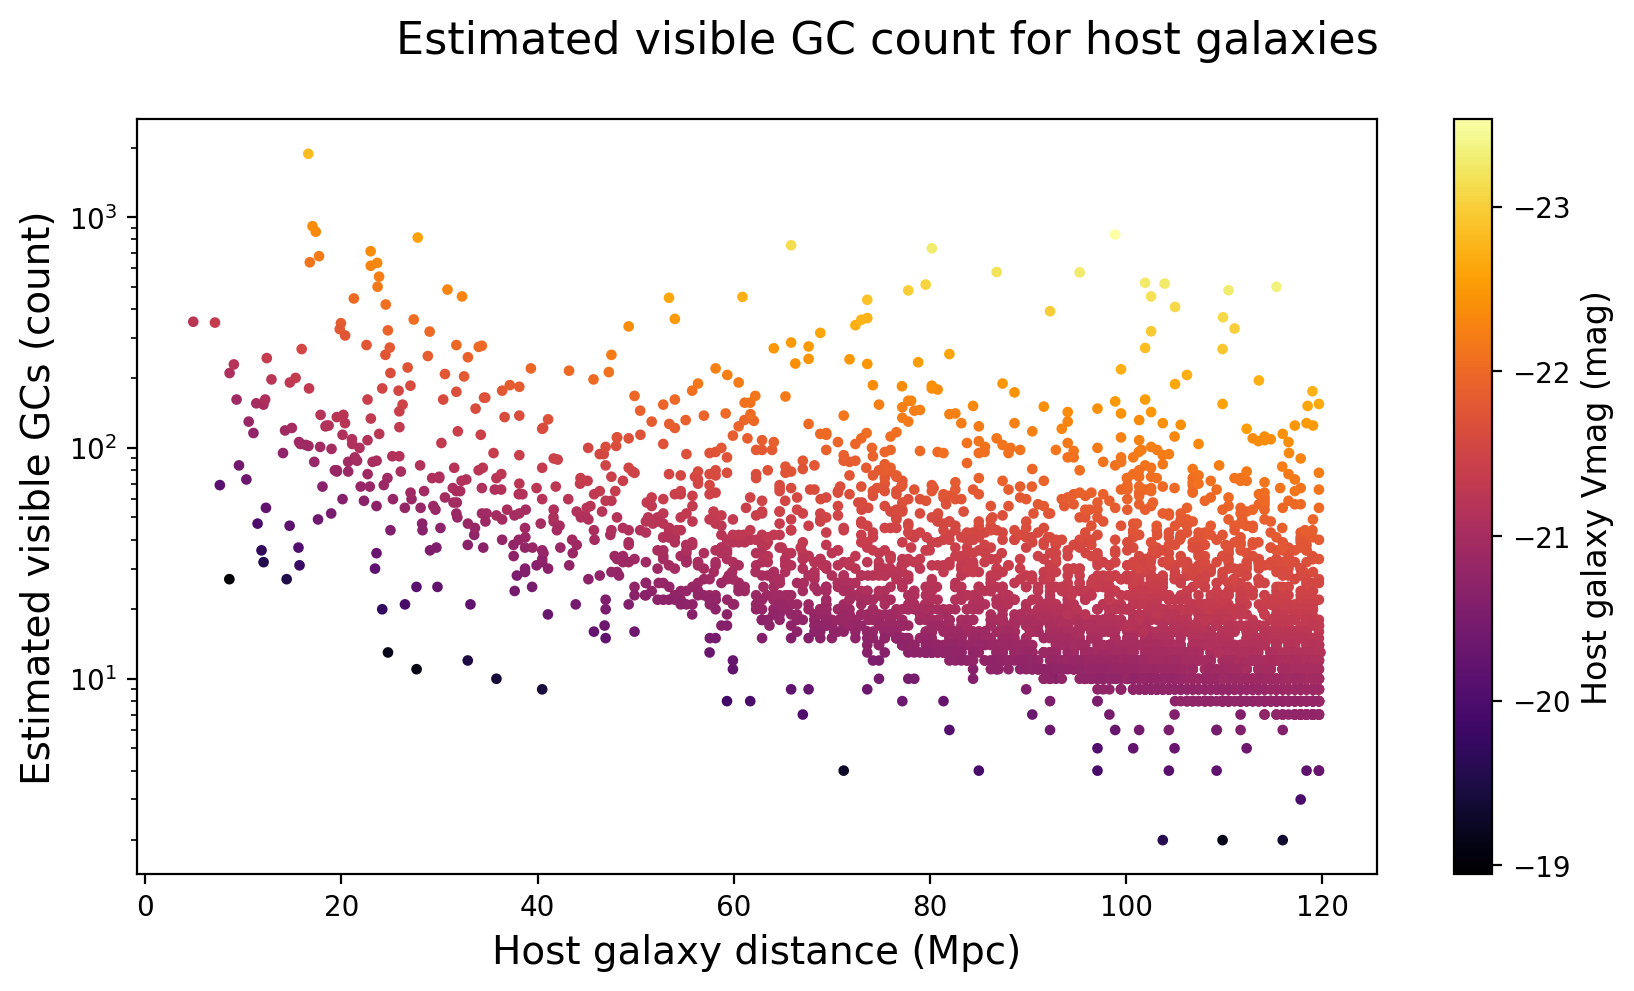

In [345]:
fig, ax = plt.subplots(figsize=(10,5), dpi=200)
cmap = cm.inferno_r

ax.scatter(HLdata['dist_Mpc'], HLdata['vis_GCs'], c=HLdata['est_Vmagt'], cmap = cmap, s=8)

#             xlabel = 'Host Galaxy distance (Mpc)', ylabel = 'Estimated visible GCs (count)')
ax.set_yscale("log")
ax.set_xlabel('Host galaxy distance (Mpc)', fontsize=14)
ax.set_ylabel('Estimated visible GCs (count)', fontsize=14)
fig.suptitle('Estimated visible GC count for host galaxies', fontsize=16)
# ax.set_title('Estimated count visible in PanSTARRS $g$ filter (limiting magnitude 22 mag)', fontsize=10)

norm = colors.Normalize(vmin=HLdata['est_Vmagt'].min(),vmax=HLdata['est_Vmagt'].max())
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
cbar.set_label(label='Host galaxy Vmag (mag)', size='large')
cbar.ax.invert_yaxis()

fig.savefig('figures/vis_GC_est.png', bbox_inches='tight')


In [355]:
HLdata.to_csv('data/HLGalaxies_filtered.csv', index=False)